In [1]:
#import libraries 
import pandas as pd
import numpy as np


In [2]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

import seaborn as sns

In [3]:
pd.options.display.max_columns = None

In [4]:
#function to read and format csv file 
#input: file
#output: df without NaNs, proper format

def read_format(file):
    df = pd.read_csv(file, header=0, parse_dates=True)
    df = df.drop(df.tail(2).index)
    #df['Open Interest'].fillna(method='ffill', inplace=True)
    
    
    return df

In [5]:
# set files to a variable
file_one = r"C:\Users\Matt\Desktop\data\subject_data.csv"

In [6]:
# read in and clean csv files to a data frame 
tables = read_format(file_one)

In [7]:
len(tables)

814

# Set Variables

In [15]:
#set variables
num_days_to_sample = 180
current_price = 9620
strike  = 11000
days_to_expiration = 8

In [16]:
days_to_train = num_days_to_sample

In [17]:
new_df = tables.iloc[-days_to_train:].copy()

In [18]:
new_df.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume
634,6/7/2019,^BTCUSD,7689.53,8127.03,7686.19,7890.29,200.76,47523
635,6/10/2019,^BTCUSD,7890.29,8069.31,7517.72,7939.20,48.91,41052
636,6/11/2019,^BTCUSD,7944.09,8051.73,7723.72,7924.73,-14.47,31510
637,6/12/2019,^BTCUSD,7927.28,8241.24,7825.80,8112.40,187.67,61938
638,6/13/2019,^BTCUSD,8116.80,8291.55,8057.80,8260.56,148.16,31919


# Option Pricing Function 

In [19]:
'''
    Objective:  sample a dataframe for the historical volatility, find the mean over the iterations and probability 
                that vol is greater than a certain vol over that period.  
    INPUT:
    dataframe: the dataframe to sample from
    iterations: how many iterations
    range_btw_dates: range of dates to sample in consecutive order
    
    straddle_to_compare: straddle to calculate what percentage of the iterations were greater 
    lost_threshold: straddle of stop loss to calculate what percentage of the iterations were greater, 
    the downside stop loss percentage
    profit_objective: straddle of objective profit to calculate what percentage of the iterations were greater, 
    the upside, profit taking
    
    OUTPUT:
    Return the list of sample means, print a variety of statistics around the sample means.  
'''

def option_calc_group_days(df, iterations, range_btw_dates, starting_price, 
                           strike_price, prob_up_move, replace = True):
    x = 0
    the_payout = []
    #max index number, since we are evaluating between dates, those dates cant exceed the size of dataframe 
    max_index = len(df) - range_btw_dates
    while x < iterations:
        #sample a row
        the_sample = df.sample()
        #grab the index number
        the_sample_index = df.index.get_loc(the_sample.iloc[0].name)
        
        #ensure the_start_index does not run off the table
        if the_sample_index < range_btw_dates:
            the_start_index = np.abs(the_sample_index - range_btw_dates)
        else:
            the_start_index = the_sample_index - range_btw_dates
            
            
        #create the range distance between start of index and btwn_the_dates  
        plus_the_index = the_start_index + range_btw_dates
        
        the_new_df = df[the_start_index:plus_the_index]
        start_price = the_new_df.head(1)['Close'].iloc[0]
        end_price = the_new_df.tail(1)['Close'].iloc[0]
        
        #selet if market is going up or down
        nums = np.random.choice([0, 1], size=1, p=[1-prob_up_move, prob_up_move])
        if nums[0] == 1:
            the_move = (((np.abs(start_price - end_price)) / start_price) + 1) * starting_price
        else: 
            the_move = 0
        
        is_it_in_the_money = the_move - strike_price
        
        if is_it_in_the_money > 0:
            payout = the_move - strike_price
        else:
            payout = 0
        
            
        
        
        the_payout.append(payout)
    
        x = x + 1 
    mean = np.mean(the_payout)
    median = np.median(the_payout)
    smallest_value = np.min(the_payout)
    great_value = np.max(the_payout)
    
    
    
    print(mean)
    print (median)
    print(smallest_value)
    print(great_value)
    
    


In [20]:
len(new_df)

180

In [21]:
new_df.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume
634,6/7/2019,^BTCUSD,7689.53,8127.03,7686.19,7890.29,200.76,47523
635,6/10/2019,^BTCUSD,7890.29,8069.31,7517.72,7939.20,48.91,41052
636,6/11/2019,^BTCUSD,7944.09,8051.73,7723.72,7924.73,-14.47,31510
637,6/12/2019,^BTCUSD,7927.28,8241.24,7825.80,8112.40,187.67,61938
638,6/13/2019,^BTCUSD,8116.80,8291.55,8057.80,8260.56,148.16,31919


In [23]:
the_list = option_calc_group_days(new_df, 10000, days_to_expiration, current_price, 
                           strike, .5, replace = True)

79.11088742902498
0.0
0.0
2294.822654221349


# Option Pricing Function Seperating Up and Down Volatility Moves

In [28]:
'''
    Objective:  sample a dataframe for the historical volatility, find the mean over the iterations and probability 
                that vol is greater than a certain vol over that period.  
    INPUT:
    dataframe: the dataframe to sample from
    iterations: how many iterations
    range_btw_dates: range of dates to sample in consecutive order
    
    straddle_to_compare: straddle to calculate what percentage of the iterations were greater 
    lost_threshold: straddle of stop loss to calculate what percentage of the iterations were greater, 
    the downside stop loss percentage
    profit_objective: straddle of objective profit to calculate what percentage of the iterations were greater, 
    the upside, profit taking
    
    OUTPUT:
    Return the list of sample means, print a variety of statistics around the sample means.  
'''

def option_calc_group_days_updown(df, iterations, range_btw_dates, starting_price, 
                           strike_price, prob_up_move, replace = True):
    x = 0
    the_payout_for_up = []
    the_payout_for_down = []
    #max index number, since we are evaluating between dates, those dates cant exceed the size of dataframe 
    max_index = len(df) - range_btw_dates
    while x < iterations:
        #sample a row
        the_sample = df.sample()
        #grab the index number
        the_sample_index = df.index.get_loc(the_sample.iloc[0].name)
        
        #ensure the_start_index does not run off the table
        if the_sample_index < range_btw_dates:
            the_start_index = np.abs(the_sample_index - range_btw_dates)
        else:
            the_start_index = the_sample_index - range_btw_dates
            
            
        #create the range distance between start of index and btwn_the_dates  
        plus_the_index = the_start_index + range_btw_dates
        
        the_new_df = df[the_start_index:plus_the_index]
        start_price = the_new_df.head(1)['Close'].iloc[0]
        end_price = the_new_df.tail(1)['Close'].iloc[0]
        
        #selet if market is going up or down
        nums = np.random.choice([0, 1], size=1, p=[1-prob_up_move, prob_up_move])
        if nums[0] == 1:
            the_move = (((np.abs(start_price - end_price)) / start_price) + 1) * starting_price
        else: 
            the_move = 0
        
        is_it_in_the_money = the_move - strike_price
        
        if is_it_in_the_money > 0:
            payout = the_move - strike_price
        else:
            payout = 0
        was_it_up_or_down_move = end_price - start_price
        if was_it_up_or_down_move >= 0:
            the_payout_for_up.append(payout)
        else:
            the_payout_for_down.append(payout)
            
            
        x = x + 1 
    mean_up = np.mean(the_payout_for_up)
    mean_down = np.mean(the_payout_for_down)
    
    median_up = np.median(the_payout_for_up)
    median_down = np.median(the_payout_for_down)
    
    least_value_up = np.min(the_payout_for_up)
    least_value_down = np.min(the_payout_for_down)
    
    most_value_up = np.max(the_payout_for_up)
    most_value_down = np.max(the_payout_for_down)
    
    

    
    print('the mean for up is', mean_up)
    print('the mean for down is', mean_down)
    
    print('the max for up is', most_value_up)
    print('the max for down is', most_value_down)
    
    print('the least for up is', least_value_up)
    print('the least for down is', least_value_down)
    
    print('the median for up is', median_up)
    print('the median for down is', median_down)
    
    
    print('the percentage of up moves', len(the_payout_for_up) / iterations)
    print('the percentage of down moves', len(the_payout_for_down) / iterations)
    

    


In [29]:
option_calc_group_days_updown(new_df, 10000, 8, current_price, 
                           strike, .5, replace = True)
    

the mean for up is 129.07868149206345
the mean for down is 22.079853210518788
the max for up is 2294.822654221349
the max for down is 640.9740124151831
the least for up is 0.0
the least for down is 0.0
the median for up is 0.0
the median for down is 0.0
the percentage of up moves 0.5436
the percentage of down moves 0.4564


# Function for Payouts in a List
Ability to remove outliers

In [42]:
def option_calc_group_list(df, iterations, range_btw_dates, starting_price, 
                           strike_price, prob_up_move, replace = True):
    x = 0
    the_payout_for_up = []
    the_payout_for_down = []
    #max index number, since we are evaluating between dates, those dates cant exceed the size of dataframe 
    max_index = len(df) - range_btw_dates
    while x < iterations:
        #sample a row
        the_sample = df.sample()
        #grab the index number
        the_sample_index = df.index.get_loc(the_sample.iloc[0].name)
        
        #ensure the_start_index does not run off the table
        if the_sample_index < range_btw_dates:
            the_start_index = np.abs(the_sample_index - range_btw_dates)
        else:
            the_start_index = the_sample_index - range_btw_dates
            
            
        #create the range distance between start of index and btwn_the_dates  
        plus_the_index = the_start_index + range_btw_dates
        
        the_new_df = df[the_start_index:plus_the_index]
        start_price = the_new_df.head(1)['Close'].iloc[0]
        end_price = the_new_df.tail(1)['Close'].iloc[0]
        
        #selet if market is going up or down
        nums = np.random.choice([0, 1], size=1, p=[1-prob_up_move, prob_up_move])
        if nums[0] == 1:
            the_move = (((np.abs(start_price - end_price)) / start_price) + 1) * starting_price
        else: 
            the_move = 0
        
        is_it_in_the_money = the_move - strike_price
        
        if is_it_in_the_money > 0:
            payout = the_move - strike_price
        else:
            payout = 0
        was_it_up_or_down_move = end_price - start_price
        if was_it_up_or_down_move >= 0:
            the_payout_for_up.append(payout)
        else:
            the_payout_for_down.append(payout)
            
            
        x = x + 1 
        
    return the_payout_for_up
    

In [43]:
a = option_calc_group_list(new_df, 8500, days_to_expiration, current_price, 
                           strike, .5, replace = True)


In [44]:
len(a) / 8500

0.5464705882352942

C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


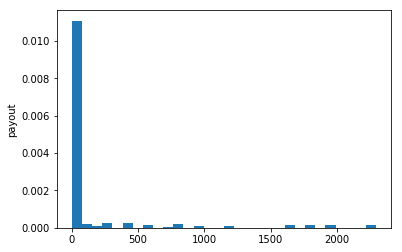

In [45]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = a
plt.hist(x, normed=True, bins=30)
plt.ylabel('payout');

In [40]:
sum(i > 2800 for i in a) / len(a)

0.0

In [20]:
outliers_removed = []
for i in a:
    if i < 2800:
        outliers_removed.append(i)
        

In [21]:
len(outliers_removed)

5411

In [22]:
np.mean(outliers_removed)

276.0822609862268